In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit as curve_fit
from scipy.optimize import minimize as minimize
from uncertainties import ufloat
from uncertainties.umath import *
from lmfit import Model
from functools import partial
%matplotlib inline

# 7. Aluminum background

In [2]:
al_bg = pd.DataFrame()
al_bg["t_s"]=[3545]
al_bg["N"] = [1000]
al_bg["I"] = al_bg.N/al_bg.t_s
al_bg["dI"] = np.sqrt(al_bg.N)/al_bg.t_s
al_bg

t_s     N         I       dI
0  3545  1000  0.282087  0.00892

# 2. Effective range of electrons

## Data preparation

In [3]:
eff_range = pd.read_csv('2_Eff_range.csv')
eff_range['I'] = eff_range.N/eff_range.t_s
eff_range['I'] = eff_range.I - al_bg.I[0]
eff_range['dN'] = np.sqrt(eff_range.N)
eff_range['dI'] = eff_range.dN/eff_range.t_s + al_bg.dI[0]
eff_range = eff_range.sort_values("d_mm")
eff_range

d_mm     N  t_s  dd_mm           I         dN        dI
0   0.00  8943   60  0.005  148.767913  94.567436  1.585044
1   0.10  4784   60  0.010   79.451246  69.166466  1.161695
4   0.20  3167   60  0.010   52.501246  56.276105  0.946855
5   0.30  2354   60  0.010   38.951246  48.518038  0.817554
2   0.35  2191   60  0.010   36.234579  46.808119  0.789056
6   0.40  1780   60  0.010   29.384579  42.190046  0.712088
7   0.55  1275   60  0.020   20.967913  35.707142  0.604039
3   0.65  1071   60  0.010   17.567913  32.726136  0.554356
8   0.75   836   60  0.030   13.651246  28.913665  0.490815
9   0.83  1081   92  0.050   11.467913  32.878564  0.366296
10  1.10  1006  122  0.050    7.963814  31.717503  0.268900
11  2.10  1002  540  0.050    1.573468  31.654384  0.067540
12  3.10  1004  990  0.050    0.732054  31.685959  0.040926

## Empirical values

$$\rho R_{eff} (g/cm^2) = [0.54 E_{max} (MeV) - 0.13], \quad\quad\quad E_{max}>0.8MeV$$
$$\rho R_{eff} (g/cm^2) = 0.41 E_{max}^{1.38} (MeV), \quad\quad 0.15MeV<E_{max}<0.8MeV$$

In [4]:
rho = 2.7
d_Y = (0.54*2.29-0.13)*10/2.7
d_Sr = 0.41*(0.546**1.38)*10/2.7
print(f"Theoretical range ({d_Sr}:{d_Y})cm")

Theoretical range (0.6587883939641643:4.098518518518519)cm


[[Model]]
    Model(<lambda>)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 341
    # data points      = 13
    # variables        = 4
    chi-square         = 8.59707007
    reduced chi-square = 0.95523001
    Akaike info crit   = 2.62413728
    Bayesian info crit = 4.88393471
[[Variables]]
    A1:  71.1489925 +/- 4.03667200 (5.67%) (init = 74.38396)
    t1: -2.15977291 +/- 0.10886512 (5.04%) (init = -1)
    A2:  77.5966654 +/- 4.09711289 (5.28%) (init = 74.38396)
    t2: -12.5018642 +/- 0.93549204 (7.48%) (init = -1)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -0.971
    C(A1, t1) = -0.952
    C(t1, A2) =  0.927
    C(A1, t2) = -0.890
    C(A2, t2) =  0.836
    C(t1, t2) =  0.787


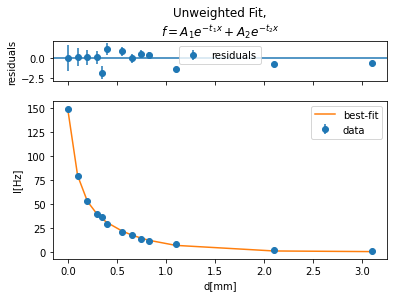

In [5]:
decay = lambda x,A,t: A*np.exp(x*t)
double_decay = lambda x,A1,t1,A2,t2: decay(x,A1,t1)+decay(x,A2,t2)
ddmodel = Model(double_decay)
# for par in ddmodel.param_names:
ddmodel.set_param_hint("A1",min = 0)
ddmodel.set_param_hint("A2",min = 0)
ddmodel.set_param_hint("t1",max = 0)
ddmodel.set_param_hint("t2",max = 0)
ddresult = ddmodel.fit(eff_range.I,x=eff_range.d_mm,A1=eff_range.I.max()/2,A2=eff_range.I.max()/2,
                       t1=-1,t2=-1)
fig = plt.figure()
fig, gridspec = ddresult.plot(fig=fig,yerr=eff_range.dI,ylabel='I[Hz]',xlabel='d[mm]')
# fig.get_axes()[1].set_yscale("log")
fig.get_axes()[0].set_title("Unweighted Fit,\n$f=A_1e^{-t_1x}+A_2e^{-t_2x}$")
# fig.suptitle("Weighted fit")
print(str.format(ddresult.fit_report()))

In [6]:
gridspec

GridSpec(2, 1, height_ratios=[1, 4])

In [7]:
print(-np.log(1/1000)/ufloat(ddresult.params['t1'].value,ddresult.params['t1'].stderr))
print(-np.log(1/1000)/ufloat(ddresult.params['t2'].value,ddresult.params['t2'].stderr))

-3.20+/-0.16
-0.55+/-0.04


### Fitting weighted sum of two exponentials using lmfit

[[Model]]
    Model(<lambda>)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 90
    # data points      = 13
    # variables        = 4
    chi-square         = 145.439480
    reduced chi-square = 16.1599422
    Akaike info crit   = 39.3925391
    Bayesian info crit = 41.6523365
[[Variables]]
    A1:  43.5196220 +/- 5.56336975 (12.78%) (init = 74.38396)
    t1: -1.51334936 +/- 0.10440632 (6.90%) (init = -1)
    A2:  101.864042 +/- 7.50136108 (7.36%) (init = 74.38396)
    t2: -7.72368303 +/- 0.95875994 (12.41%) (init = -1)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, t1) = -0.886
    C(A1, t2) = -0.785
    C(t1, t2) =  0.614
    C(A1, A2) = -0.601
    C(t1, A2) =  0.560
    C(A2, t2) =  0.208


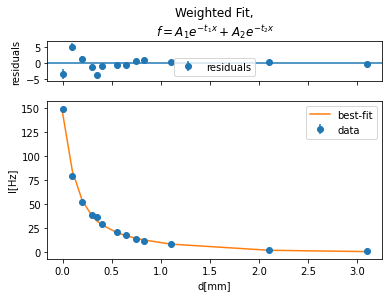

In [8]:
decay = lambda x,A,t: A*np.exp(x*t)
double_decay = lambda x,A1,t1,A2,t2: decay(x,A1,t1)+decay(x,A2,t2)
ddmodel = Model(double_decay)
# for par in ddmodel.param_names:
ddmodel.set_param_hint("A1",min = 0)
ddmodel.set_param_hint("A2",min = 0)
ddmodel.set_param_hint("t1",max = 0)
ddmodel.set_param_hint("t2",max = 0)
ddresult = ddmodel.fit(eff_range.I,x=eff_range.d_mm,A1=eff_range.I.max()/2,A2=eff_range.I.max()/2,
                       t1=-1,t2=-1,weights=1/eff_range.dI)
fig = plt.figure()
fig, gridspec = ddresult.plot(fig=fig,yerr=eff_range.dI,ylabel='I[Hz]',xlabel='d[mm]')
# fig.get_axes()[1].set_yscale("log")
fig.get_axes()[0].set_title("Weighted Fit,\n$f=A_1e^{-t_1x}+A_2e^{-t_2x}$")
# fig.suptitle("Weighted fit")
print(str.format(ddresult.fit_report()))

In [9]:
print(-np.log(1/1000)/ufloat(ddresult.params['t1'].value,ddresult.params['t1'].stderr))
print(-np.log(1/1000)/ufloat(ddresult.params['t2'].value,ddresult.params['t2'].stderr))

-4.56+/-0.31
-0.89+/-0.11


### Sum of exponentials with same amplitude

[[Model]]
    Model(<lambda>)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 41
    # data points      = 13
    # variables        = 3
    chi-square         = 381.937670
    reduced chi-square = 38.1937670
    Akaike info crit   = 49.9440049
    Bayesian info crit = 51.6388530
[[Variables]]
    A1:  70.3165338 +/- 4.54618857 (6.47%) (init = 74.38396)
    t1: -2.01368461 +/- 0.11484392 (5.70%) (init = -1)
    t2: -12.4149760 +/- 3.74652887 (30.18%) (init = -10)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, t2) = -0.665
    C(A1, t1) = -0.651
    C(t1, t2) =  0.287


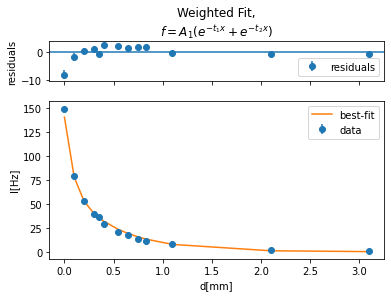

In [10]:
decay = lambda x,A,t: A*np.exp(x*t)
double_decay = lambda x,A1,t1,t2: decay(x,A1,t1)+decay(x,A1,t2)
ddmodel = Model(double_decay)
# for par in ddmodel.param_names:
ddmodel.set_param_hint("A1",min = 0)
ddmodel.set_param_hint("t1",max = 0)
ddmodel.set_param_hint("t2",max = 0)
ddresult = ddmodel.fit(eff_range.I,x=eff_range.d_mm,A1=eff_range.I.max()/2,
                       t1=-1,t2=-10,weights=1/eff_range.dI)
fig = plt.figure()
fig, gridspec = ddresult.plot(fig=fig,yerr=eff_range.dI,ylabel='I[Hz]',xlabel='d[mm]')
# fig.get_axes()[1].set_yscale("log")
fig.get_axes()[0].set_title("Weighted Fit,\n$f=A_1(e^{-t_1x}+e^{-t_2x})$")
# fig.suptitle("Weighted fit")
print(str.format(ddresult.fit_report()))

In [11]:
print(-np.log(1/1000)/ufloat(ddresult.params['t1'].value,ddresult.params['t1'].stderr))
print(-np.log(1/1000)/ufloat(ddresult.params['t2'].value,ddresult.params['t2'].stderr))

-3.43+/-0.20
-0.56+/-0.17


### back of envelope air decay estimation

Estimating the range in air using a measurement of distance to detector by eye (20-50cm)

In [12]:
rho = 2.7
d_Y = (0.54*2.29-0.13)*10/0.0012
d_Sr = 0.41*(0.546**1.38)*10/0.0012
print(f"Theoretical range in air ({d_Sr}:{d_Y})cm")
ratiomin = np.exp(-50*np.log(1000)/d_Sr)/np.exp(-50*np.log(1000)/d_Y)
ratiomax = np.exp(-20*np.log(1000)/d_Sr)/np.exp(-20*np.log(1000)/d_Y)
ratiomin,ratiomax

Theoretical range in air (1482.27388641937:9221.66666666667)cm


(0.8223755068977859, 0.9247579356765034)

[[Model]]
    Model(<lambda>)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 51
    # data points      = 13
    # variables        = 4
    chi-square         = 421.051467
    reduced chi-square = 46.7834964
    Akaike info crit   = 53.2114743
    Bayesian info crit = 55.4712718
##  Warning: uncertainties could not be estimated:
    A2:  at initial value
    A2:  at boundary
[[Variables]]
    A1:  72.6848604 (init = 74.38396)
    t1: -2.06271594 (init = -1)
    A2:  0.92475794 (init = 0.9247579)
    t2: -12.9864797 (init = -10)


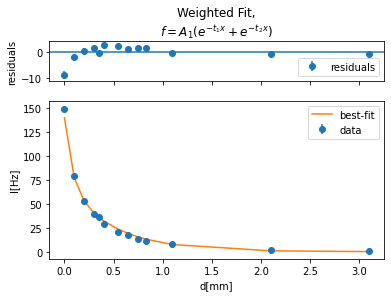

In [13]:
decay = lambda x,A,t: A*np.exp(x*t)
double_decay = lambda x,A1,t1,A2,t2: decay(x,A1,t1)+A2*decay(x,A1,t2)
ddmodel = Model(double_decay)
# for par in ddmodel.param_names:
ddmodel.set_param_hint("A1",min = 0)
ddmodel.set_param_hint("A2",min = ratiomin)
ddmodel.set_param_hint("A2",min = ratiomax)
ddmodel.set_param_hint("t1",max = 0)
ddmodel.set_param_hint("t2",max = 0)
ddresult = ddmodel.fit(eff_range.I,x=eff_range.d_mm,A1=eff_range.I.max()/2, A2=(ratiomin+ratiomax)/2,
                       t1=-1,t2=-10,weights=1/eff_range.dI)
fig = plt.figure()
fig, gridspec = ddresult.plot(fig=fig,yerr=eff_range.dI,ylabel='I[Hz]',xlabel='d[mm]')
# fig.get_axes()[1].set_yscale("log")
fig.get_axes()[0].set_title("Weighted Fit,\n$f=A_1(e^{-t_1x}+e^{-t_2x})$")
# fig.suptitle("Weighted fit")
print(str.format(ddresult.fit_report()))

### No range estimation as A2 goes to boundary and so uncertainties cannot be esimated

In [14]:
print(-np.log(1/1000)/ddresult.params['t1'].value)
print(-np.log(1/1000)/ddresult.params['t2'].value)

-3.348864056486986
-0.5319190003504851


In [15]:
t1 = ddresult.params['t1']
minimizer1 = lambda t,x: (1000*np.exp(t*x) - 1)**2
range1 = minimize(partial(minimizer1,t1),1).x
range1

array([3.34886405])

In [16]:
t2 = ddresult.params['t2']
minimizer1 = lambda t,x: (1000*np.exp(t*x) - 1)**2
range2 = minimize(partial(minimizer1,t2),1).x
range2

array([0.53191899])